### Installing required libraries

In [ ]:
pip install timesfm==1.1.0 numpy==1.26.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import timesfm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

2024-09-16 05:26:05.430443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

In [ ]:
# To load local csv  > modify to the right path where the file is present
Y_df = pd.read_csv('AirPassengersDataset.csv')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df = Y_df.reset_index(drop=True)
Y_df.head()

,unique_id,ds,y
0,1,1949-01-31,112
1,1,1949-02-28,118
2,1,1949-03-31,132
3,1,1949-04-30,129
4,1,1949-05-31,121


In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

In [ ]:
timesfm_backend = "cpu"  # @param

from jax._src import config
config.update(
    "jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend]
)

In [ ]:
# Initialize the TimesFM model with specified parameters
tfm = timesfm.TimesFm(
    context_len=128,       # Length of the context window for the model
    horizon_len=12,        # Forecasting horizon length
    input_patch_len=32,    # Length of input patches
    output_patch_len=128,  # Length of output patches
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)

In [ ]:
# Load the pretrained model checkpoint
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=Y_train_df,       # Input DataFrame containing the time-series data for training
    freq="MS",             # Frequency of the time-series data (e.g., monthly start)
    value_name="y",        # Name of the column containing the values to be forecasted
    num_jobs=-1,           # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)
timesfm_forecast = timesfm_forecast[["ds","timesfm"]]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 5.08 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 5.39 seconds.
Jitting decoding.
Jitted decoding in 38.90 seconds.
Processing dataframe with multiple processes.


2024-09-16 05:27:47.052212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Finished preprocessing dataframe.
Finished forecasting.


In [ ]:
timesfm_forecast.head()

,ds,timesfm
0,1960-01-01,410.117157
1,1960-02-01,381.156982
2,1960-03-01,441.656921
3,1960-04-01,432.986389
4,1960-05-01,450.837585


Check how good model works on test data

In [ ]:
calculate_error_metrics(Y_test_df[['y']],timesfm_forecast['timesfm'])

MSE : 770.0660279974496
RMSE : 27.75006356744881
MAPE : 0.04984703514028369
r2 : 0.8609856684706817
adjusted_r2 : 0.8470842353177499


Plot Actual vs Predicted

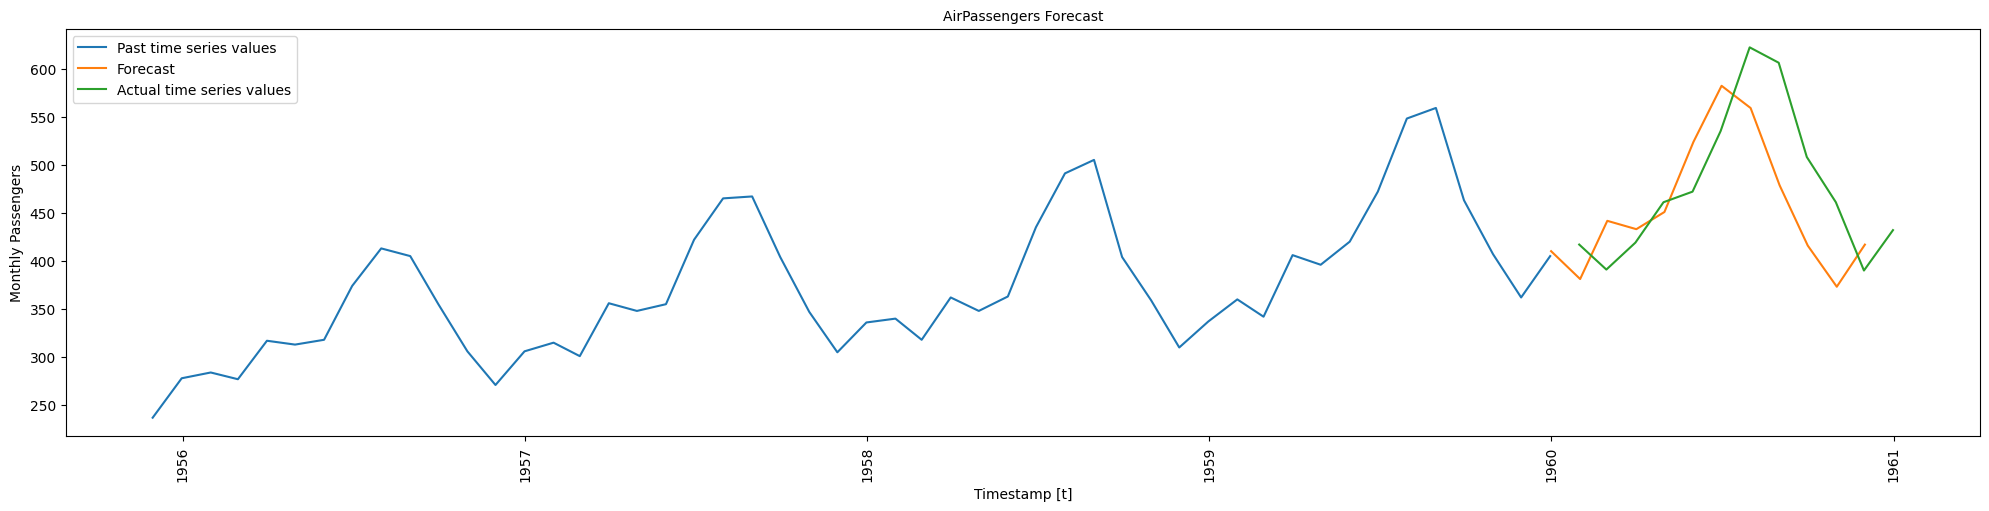

In [ ]:
Y_train_df.set_index('ds',inplace =True)
timesfm_forecast.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)
plt.figure(figsize=(20, 5))
y_past = Y_train_df["y"][-50:]
y_pred = timesfm_forecast['timesfm']
y_test = Y_test_df["y"]
plt.plot(y_past, label="Past time series values")
plt.plot(timesfm_forecast, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend();